# ARIMA Modeling

In this section we're going to begin fitting our data to ARIMA models and make predictions about the increase of COVID-19 cases in America.  

Due to time constraints, we will only be modeling the states with the top 5 highest number of cases.  If you remember from notebook 2, those states are California, Florida, Georgia, New York, and Texas.

Time to get started!

# Importing Data

In [3]:
import warnings
warnings.filterwarnings('ignore')
import itertools
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import math
import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras.utils import Sequence
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from keras.callbacks import EarlyStopping
from datetime import timedelta
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as MSE
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
sns.set_style('darkgrid')

import helper_functions
from helper_functions import acf_pacf
from helper_functions import decompose_time_series
from helper_functions import train_test
from helper_functions import preprocess_data
from helper_functions import create_dataset
from helper_functions import fit_model

Using TensorFlow backend.


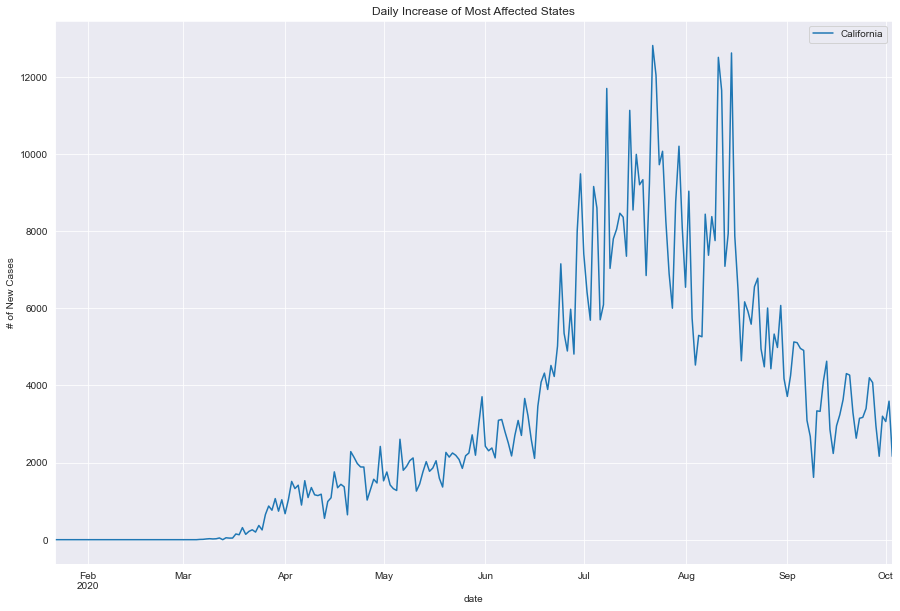

In [4]:
df = pd.read_csv('csv_files/national_positive_increase.csv')

# Rename 'Unnamed' to 'date'
df = df.rename(columns={'Unnamed: 0' : 'date'})

# Changing 'date' to date-time 
df['date'] = pd.to_datetime(df['date'])

# Set to index
df = df.set_index('date')

df = df.asfreq('D')

# California
ca = df['CA_positiveIncrease']
ca.plot(figsize=(15, 10), label='California')

plt.ylabel('# of New Cases')
plt.title('Daily Increase of Most Affected States')
plt.legend()
plt.show();

Awesome! We remember this messy plot from notebook 2!  Now, since we only have **data between the end of January and the beginning of October**, we shouldn't need to resample.  256 values per state is **low enough**, all things considered. If we resampled by the week, that would leave us with ~ 36 weeks, which might not be a enough data to get accurate data.

As you can see, none of these plots are stationary. Luckily, SARIMA allows us to **integrate differencing** by providing the arguments `d` and `D` in the order and seasonal order during modeling.   

Now that we've loaded the dataframe and subset our data, let's go ahead and get started.

**Important Note**: Normally my **first step would be to check for stationarity**, but it's **quite obvious from the plot** that we are dealing with a **non-stationary time series**, as it has both a positive and negative exponential trend.  While you can make the argument that doing a stationarity check will help me calculate the amount of differencing necessary to make it stationary, but I counter that with how we'll be able to obtain that value through grid searching after we find the values for `p`, `q`, and `s` through analyzing autocorrelation and time series decomposition.  

# California

## Auto-Correlation and Decomposition
Since (S)ARIMA models require that you calculate the values for AR(p), MA(q), differencing, and seasonality, we'll first start by checking how strong the correlation between different lags and then move on to creating ACF and PACF plots to calculate the potential range for `q` and `p` respectively.  Afterwards we'll use decomposition to calculate the seasonality. 

## Calculating Q

In [3]:
def lag(df, n):
    '''
    Input: Dataframe and 'n' number of periods(int)
    Output: Dataframe that contains concatenation of the lag shifted data and 
    original dataframe.
    '''
    # Shift data by 'n' number of periods
    shift = df.shift(periods=n)
    
    # Concat new data with original dataframe
    concat = pd.concat([shift, df], axis=1)
    
    return concat

In [4]:
# California Auto-Correlation
ca_lag_1 = lag(ca, 1)

# Check correlation after day lag
ca_lag_1.corr()

,CA_positiveIncrease,CA_positiveIncrease
CA_positiveIncrease,1.000000,0.925779
CA_positiveIncrease,0.925779,1.000000


Ok, as to be expected, it's very correlated after a single lag (equal to 1 day). Let's take a look at correlation after 7-days. 

In [5]:
ca_lag_7 = lag(ca, 7)
ca_lag_7.corr()

,CA_positiveIncrease,CA_positiveIncrease
CA_positiveIncrease,1.000000,0.878137
CA_positiveIncrease,0.878137,1.000000


That's actually a pretty strong correlation after a week.  Because COVID-19 has an incubation period of up to 14 days, let's try 14 next.

In [6]:
ca_lag_14 = lag(ca, 14)

ca_lag_14.corr()

,CA_positiveIncrease,CA_positiveIncrease
CA_positiveIncrease,1.000000,0.816383
CA_positiveIncrease,0.816383,1.000000


This is very interesting. There is still very high correlation.  Let's see how long this goes on for.

<Figure size 1440x1008 with 0 Axes>

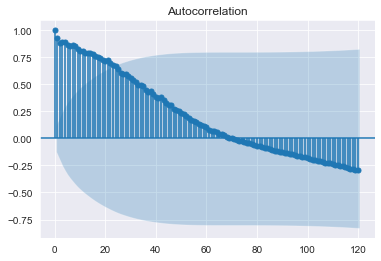

In [7]:
from statsmodels.graphics.tsaplots import plot_acf


plt.figure(figsize=(20,14))
plot_acf(ca, lags = 120);

Also, notice how this plot tails off instead of cutting off \[implying a higher order of ARMA(1, 0)\].  According to the ACF plot, this correlation remains strong when you count back 22 days!  Our q-value could **potentially be up to 22**, but let's check out the PACF plot and see **which lags are most significant**.  

## Calculating P

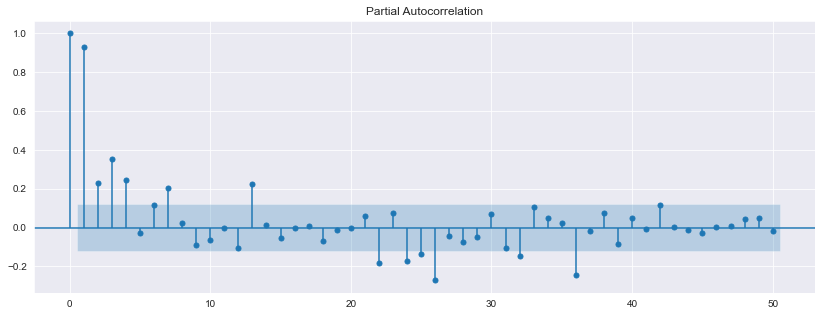

In [5]:
from statsmodels.graphics.tsaplots import plot_pacf

from matplotlib.pylab import rcParams

rcParams['figure.figsize'] = 14, 5


plot_pacf(ca, lags=50);

The PACF plot tells us that the **last 5 lags** are the most significant. The plot also shows sharp drop in significance, confirms that we're looking at an AR model.  So it would seem that our p-value is up to 5.  

Now let's find out the seasonality.

## Seasonality

<Figure size 1440x720 with 0 Axes>

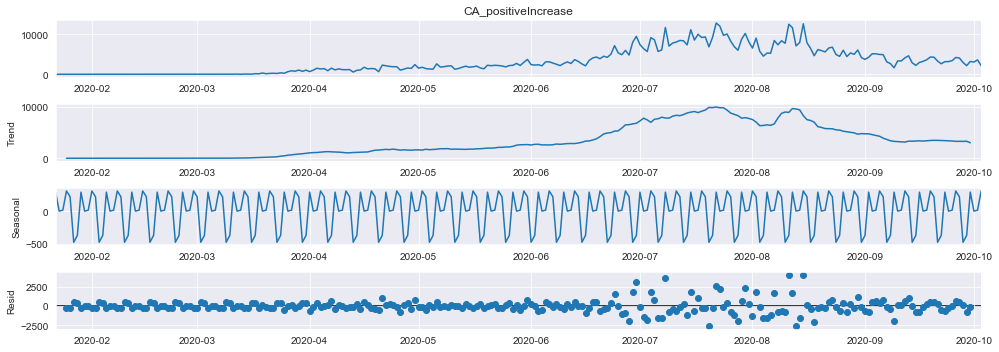

In [6]:
from statsmodels.tsa.seasonal import seasonal_decompose
decompose_time_series(ca)

It appears that there are **about 4 or 5 seasonal periods per month**.  This corresponds to the number of weeks in a month.  So our s-value is about 7 days.

## Bringing it all together

Now that we have our ranges for P, D, Q, and S, we can create a grid search to find the optimal parameters for our SARIMA model.

In [10]:
def pdq_parameters(timeseries, p_range = 2, d_range = 2, q_range = 2, s = 0):
    '''
    Input: Time Series Dataframe, range values for ARIMA(p, d, q), and an 
    optional value for seasonality (s).
    
    The function will generate values between within the given range (default 
    between 0 and 1) for p, d, and q, compile them into lists and run them 
    through a model fit to the given time series.
    
    It will return a list of the parameters and their associate AIC scores.  
    '''

    # Define the p, d and q parameters to take any value between 0 and 2
    p = range(p_range)
    d = range(d_range)
    q = range(q_range)

    # Generate all combinations of p, q and q triplets
    pdq = list(itertools.product(p, d, q))

    pdqs = [(x[0], x[1], x[2], s) for x in list(itertools.product(p, d, q))]

    # Finding optimal results
    results = []
    for combination in pdq:
        for combinations in pdqs:
            try:
                mod = sm.tsa.statespace.SARIMAX(timeseries,
                                                order=combination,
                                                seasonal_order=combinations,
                                                enforce_stationarity=True,
                                                enforce_invertibility=False)

                output = mod.fit()
                results.append([combination, combinations, output.aic])
            
            except:
                continue
    return results

In [11]:
ca_parameters = pdq_parameters(ca, p_range=6, d_range=2, q_range=6, s=7)

In [12]:
ca_parameters

[[(0, 0, 0), (0, 0, 0, 7), 5032.87302448085],
 [(0, 0, 0), (0, 0, 1, 7), 4806.360598792187],
 [(0, 0, 0), (0, 0, 2, 7), 4714.573068839068],
 [(0, 0, 0), (0, 0, 3, 7), 4628.9124779347185],
 [(0, 0, 0), (0, 0, 4, 7), 4576.564932519232],
 [(0, 0, 0), (0, 0, 5, 7), 4566.918141519094],
 [(0, 0, 0), (0, 1, 0, 7), 4369.734657407144],
 [(0, 0, 0), (0, 1, 1, 7), 4356.089371856607],
 [(0, 0, 0), (0, 1, 2, 7), 4357.009848232952],
 [(0, 0, 0), (0, 1, 3, 7), 4344.886149505839],
 [(0, 0, 0), (0, 1, 4, 7), 4346.822434615648],
 [(0, 0, 0), (0, 1, 5, 7), 4347.094850998274],
 [(0, 0, 0), (1, 0, 0, 7), 4495.910778096732],
 [(0, 0, 0), (1, 0, 1, 7), 4485.186891056126],
 [(0, 0, 0), (1, 0, 2, 7), 4483.856885273894],
 [(0, 0, 0), (1, 0, 3, 7), 4472.739407702672],
 [(0, 0, 0), (1, 0, 4, 7), 4474.713225307114],
 [(0, 0, 0), (1, 0, 5, 7), 4473.298453085336],
 [(0, 0, 0), (1, 1, 0, 7), 4355.757490975116],
 [(0, 0, 0), (1, 1, 1, 7), 4357.381652968344],
 [(0, 0, 0), (1, 1, 2, 7), 4350.946467539554],
 [(0, 0, 0), 

Now let's find out what the best parameters are.

In [13]:
def best_params(ts_param_list):
    '''
    Input: list of pdq parameters
    
    Function appends all AIC scores to a list, finds the minimum value, and 
    returns the corresponding parameters
    
    Output: Parameters for SARIMA Modeling
    '''

    # List for storing AIC values
    aic = []
    
    # Store AIC values
    for i in range(len(ts_param_list)):
        aic.append(ts_param_list[i][2])
    
    # List for storing best parameters. Using List in case there are multiple 
    # parameters that create the same AIC 
    best = []
    
    # Find parameters associated with lowest AIC
    for i in range(len(ts_param_list)):
        if ts_param_list[i][2] == min(aic):
            best.append(ts_param_list[i])

    return best

In [14]:
best_params(ca_parameters)

[[(3, 1, 0), (0, 1, 1, 7), 4170.587071953259]]

So after 9 and a half hours we found our best parameters.  We'll have to do this four more times, meaning that we could potentially end up spending close to 48 hours just computing parameters.  Let's enlist the help of Auto ARIMA and compare AIC scores.  

The Auto-ARIMA function is a **Python derivative** of a function used in the R programming language which finds the best seasonal and non-seasonal parameters and in a fraction of the time.

In [60]:
import pmdarima as pm

ca_results = pm.auto_arima(ca,information_criterion='aic', m=7 ,start_d=0, 
                           max_d=2,
                        start_p=1,start_q=1, max_p=6, max_q=22,
                        stepwise=True,trace=True,error_action='ignore',
                           suppress_warnings=True)
ca_results

Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 0, 1, 7); AIC=4291.891, BIC=4313.139, Fit time=0.642 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 7); AIC=4346.882, BIC=4353.964, Fit time=0.016 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 0, 0, 7); AIC=4327.355, BIC=4341.520, Fit time=0.076 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 1, 7); AIC=4296.797, BIC=4310.962, Fit time=0.333 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 1, 7); AIC=4289.732, BIC=4307.438, Fit time=0.393 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 0, 7); AIC=4293.169, BIC=4307.334, Fit time=0.196 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 2, 7); AIC=4291.210, BIC=4312.458, Fit time=1.117 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 0, 2, 7); AIC=4293.375, BIC=4318.164, Fit time=0.668 seconds
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 0, 1, 7); AIC=4285.260, BIC=4306.508, Fit time=0.174 seconds
Fit ARIMA: order=(2, 1, 0) seasonal_o

ARIMA(callback=None, disp=0, maxiter=None, method=None, order=(3, 1, 0),
      out_of_sample_size=0, scoring='mse', scoring_args={},
      seasonal_order=(1, 0, 1, 7), solver='lbfgs', start_params=None,
      suppress_warnings=True, transparams=True, trend=None,
      with_intercept=True)

Ok, so the AIC is a little bit higher, but not by much, and we completed this in under 20 seconds! For California, we'll use the parameters that we painstakingly waited for, but our other 4 states, we'll use Auto-ARIMA.  

Let's go ahead and split our data now.

In [61]:
df_train, df_test = train_test(df)

In [62]:
len(df_train.index)

205

Perfect! The dataframe is split now, so lets make training and test sets for California.

In [63]:
ca_train = df_train[['CA_positiveIncrease']]

ca_test = df_test[['CA_positiveIncrease']]

ca_train


,CA_positiveIncrease
date,
2020-01-22,0
2020-01-23,0
2020-01-24,0
2020-01-25,0
2020-01-26,0
...,...
2020-08-09,8373
2020-08-10,7751
2020-08-11,12500


## Fitting Model

In [98]:
def fit_model(series_train, pdq=(1,0,1),pdqs=(0,0,0,1)):
    '''
    Input: a training and test set that are in Series format, the order, and 
    seasonal order for Time Series modeling
    
    Function compiles the model and fits it to the training set. Then prints 
    the model summary and plots the diagnostic report.
    
    Returns: fit model results
    '''
    
    model = sm.tsa.statespace.SARIMAX(series_train,order=pdq,seasonal_order=pdqs)
    results = model.fit()
    results.summary
    residuals = results.resid
    print(results.summary())
    results.plot_diagnostics(figsize=(11,8))
    plt.show();
    return results

                                      SARIMAX Results                                      
Dep. Variable:                 CA_positiveIncrease   No. Observations:                  205
Model:             SARIMAX(3, 1, 0)x(0, 1, [1], 7)   Log Likelihood               -1648.307
Date:                             Wed, 14 Oct 2020   AIC                           3306.614
Time:                                     12:31:54   BIC                           3323.030
Sample:                                 01-22-2020   HQIC                          3313.260
                                      - 08-13-2020                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4290      0.047     -9.152      0.000      -0.521      -0.337
ar.L2         -0.4229      

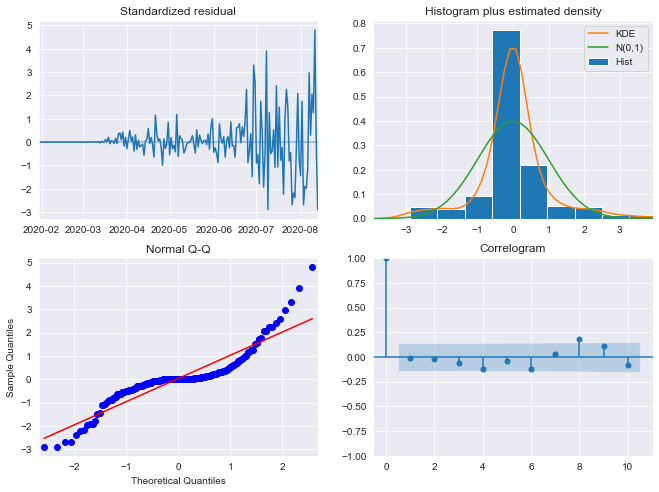

In [65]:
pdq = (3, 1, 0)
pdqs = (0, 1, 1, 7)
results = fit_model(ca_train, ca_test, pdq=pdq, pdqs=pdqs)

In [99]:
def test_RMSE(series_train, series_test, pdq, pdqs, display=True):
    '''
    Input: training and test set, the order, and seasonal order for ARIMA 
    modeling.  
    
    Creates list of predictions by fitting the model to the training values, 
    creating a forecast and recording the predicted values.  Making use of 
    Scikit Learn's MSE function, the test and prediction values are passed 
    through as arguements and then the function prints the square root of the 
    result.
    
    Outputs: RMSE for model and plot of Test predictions against actual values 
    from model.
    '''
    
    
    X_train = series_train.values
    X_test = series_test.values
    train, test = X_train, X_test
    history = [x for x in train]
    predictions = []
    for t in range(len(test)):
        model = sm.tsa.statespace.SARIMAX(history, order=pdq,seasonal_order=pdqs)
        fit_model = model.fit(disp=0)
        output = fit_model.forecast()
        yhat = output[0]
        predictions.append(yhat)
        history.append(test[t])
    rmse = np.sqrt(MSE(test, predictions))
    print('SARIMA model RMSE on test data: %.5f' % rmse)
    if display:
        plt.figure(figsize=(13,6))
        plt.title('Actual Test Data vs. Predictions')
        plt.plot(history[-51:],label='Actual', color='b')
        plt.plot(predictions,label='Predictions',color='r')
        plt.legend(loc='best')
        plt.show()

def train_RMSE(train, results, display = True):
    '''
    Input: training set and results of fitted model.  
    
    Creates list of predictions by use of model_results.predict() function. 
    Making use of Scikit Learn's MSE function, the test and prediction values 
    are passed through as arguements and then the function prints the square 
    root of the product.
    
    Outputs: RMSE for model and plot of train set predictions against actual 
    values from model.
    '''
    
    train_pred = results.predict(-56)
    rmse = np.sqrt(MSE(train[-56:],train_pred))
    print(f'SARIMA model RMSE on train data: %.5f' % rmse)
    if display:
        plt.figure(figsize=(13,6))
        train[:].plot(label='Actual',color='b')
        train_pred.plot(label='Predicted',color='r')
        plt.legend(loc='best')
        plt.title('Actual Train Data vs. Predictions')
        plt.show()

SARIMA model RMSE on train data: 1838.36525


<Figure size 936x432 with 0 Axes>

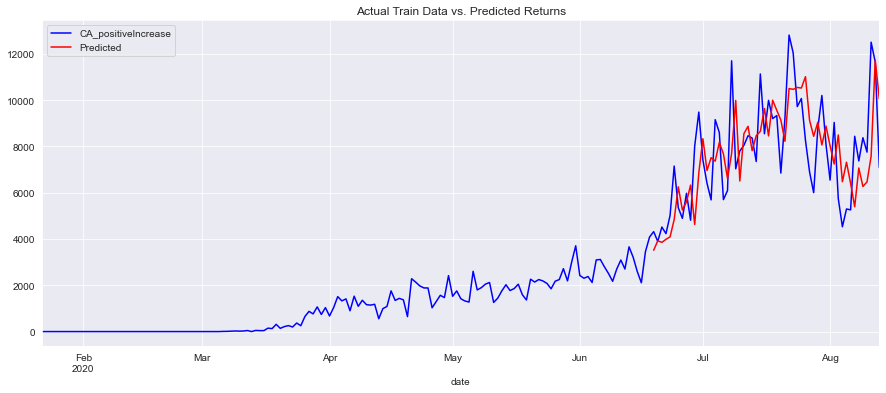

In [92]:
train_RMSE(ca_train, results)

SARIMA model RMSE on test data: 1204.54756


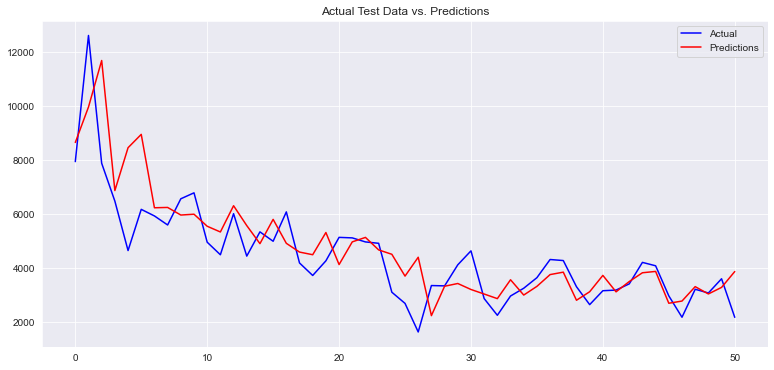

In [87]:
test_RMSE(ca_train, ca_test, pdq, pdqs)

# Forecasting on Dataset

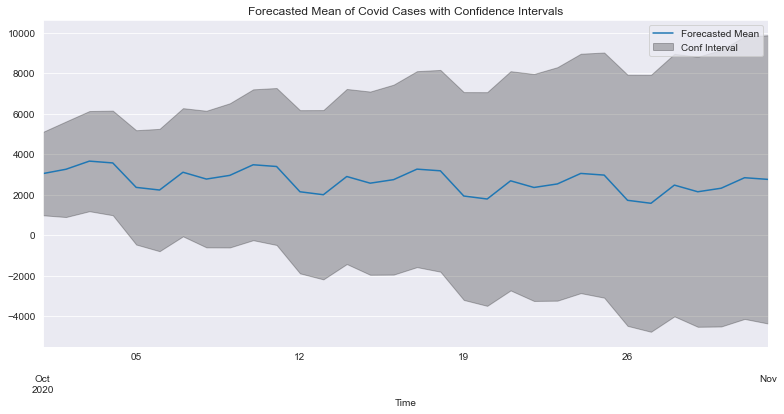

In [95]:
pdq = (3, 1, 0)
pdqs = (0, 1, 1, 7)
#train, test, results = fit_model(ca, ca_test, pdq=pdq, pdqs=pdqs)

model = sm.tsa.statespace.SARIMAX(ca, order=pdq,seasonal_order=pdqs)
fit_model = model.fit()
output = fit_model.get_prediction(start='2020-10-01',end='2020-11-01', dynamic=True)
forecast_ci = output.conf_int()
fig, ax = plt.subplots(figsize=(13,6))
output.predicted_mean.plot(label='Forecasted Mean')
ax.fill_between(forecast_ci.index,forecast_ci.iloc[:, 0],forecast_ci.iloc[:, 1],
                        color='k', alpha=.25,label='Conf Interval')
plt.title('Forecasted Mean of Covid Cases with Confidence Intervals')
plt.xlabel('Time')
plt.legend(loc='best');
plt.show()

According to this forecast the average number of cases in California will **vacillate between 2000 and 4000** as it slowly decreases towards the end of the month.  Again this is the **estimated mean** and the real number can fall anywhere within the confidence interval.  The fact that the **confidence intervals are so large** is probably due to the **heteroskedacity of the residuals** during the summer months.  The exponential increase in the number of cases, followed by steep drops and sudden spikes, makes it very difficult to make predictions on.  However, The New York Times reported that, on October 5th, California had **3,273 confirmed cases**.  The mean prediction from the forecast here is **between 2000 and 2500**.  This is within the range of test set's Root Mean Squared Error (1200).  Let's see if we can improve on this via usage of Long Short-Term Memory Neural Networks.

# LSTMs

In this notebook, we're going to utilize LSTM neural networks to help with time series forecasting.  LSTMs were **traditionally used in Natural Language Processing and Speech Recognition** because they rely on past information to contextualize current information.  This is similar to how Time Series Analysis uses the values of the past to predict current and future values.  This similarity is the reason that LSTMs have become more popular in Time Series modeling and forecasting. 

Before we get modeling, however, our data needs to be in a certain format before we feed it into our network.  Time for some more preprocessing!

## Converting from Time Series to Supervised Learning Problem
This might seem like a weird concept since Time Series Analysis IS a form of supervised learning, so let's clarify this.  In traditional ARMA and (S)ARIMA modeling, the data needs to be in a format of a series with the dates in the index (for easy manipulation) and the values in a column.  This means that your data is in a sequence.  For our LSTM to work, we need to **change the data from a sequence to input** (`X`) and **output** (`y`) pairs, where `X` is "today" (`t`) and `y` is equal to "tomorrow" (`t + 1`).  To do this, we'll need to scale our data and convert them from an array of values to a matrix.

### Scaling Data

A single LSTM layer will utilize a "**forget gate**", an "**input gate**", and an "**output gate**". Each of these gates use **sigmoid function** in one way or another.  Because of this, we're going to put our data on a scale of 0 to 1. We also want this data normalized simply because the range of values is so large.  Each state has a minimum of 0 and will eventually have values in the thousands and ten thousands.  So scaling also helps make our data more "stationary", in a sense.

### Train, Validation, and Test Splits

Once we've scaled the data we'll split up the sets so that the validation has 14 days, and the test set has 7 days.  This should be a good split considering that the seasonality of the time series seems to be weekly across the board.

In [27]:
# Instantiate scaler
scaler = MinMaxScaler(feature_range=(0, 1))

def preprocess_data(df, column):
    '''
    Input DataFrame and column name
    
    Function will create a numpy array from the values and set them to float.
    The values will be reshaped and normalized.  Next the dataset will be 
    split into training, validation, and test sets.
    
    Returns: Training, Validation, and Test sets
    '''
    # Reset Index
    df = df.reset_index()
    
    # Create a series of only the values of the specified columns
    df = df[column].values
    
    # Reshape and convert to numpy array
    df = np.reshape(df, (-1, 1))
    
    # Normalize data
    df = scaler.fit_transform(df)
    
    # Define stopping points for Train and Validation Sets 
    train_stop = int(len(df) - 21)
    val_stop = int(train_stop + 7)
    
    # Define indices for train, val, and test
    train, val, test = df[0:train_stop,:], df[train_stop:val_stop,:], df[val_stop:,:]
    
    return train, val, test


In [28]:
ca_train, ca_val, ca_test = preprocess_data(ca, 'CA_positiveIncrease')

print(f"Train has {len(ca_train)} values")
print(f"Validation has {len(ca_val)} values")
print(f"Test has {len(ca_test)} values")

Train has 235 values
Validation has 7 values
Test has 14 values


### Reshaping Dataset

We're going to reshape the datasets twice.  The first time will be to reshape the datasets so that we have input-output pairs (X and y, where X = t and y = t + 1).

After that, we'll reshape the data again so that they match the LSTM input layer requirements when we fit the model.  They will need to be 3-dimensional and those dimensions will represent the number of samples, the number of time-steps, and the number of features.

In [29]:
def create_dataset(dataset, look_back=1):
    '''
    Input: dataset and the number of days to look back (lags).
    
    Function creates lists for X and y. The function iterates through the 
    dataset and appends the lists such that X = t and y = t + look_back
    
    Returns: numpy arrays for X and y
    '''
    
    X, y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(y)

In [30]:
look_back = 1

X_train, y_train = create_dataset(ca_train, look_back)
X_val, y_val = create_dataset(ca_val, look_back)
X_test, y_test = create_dataset(ca_test, look_back)

# Reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_val = np.reshape(X_val, (X_val.shape[0], 1, X_val.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

### Modeling
Now we'll use this basic architecture of **100 neurons in the LSTM layer**, followed by a **Dropout layer**, set to 20%, and end with a **Dense layer** with a single neuron.  We'll be using **ADAM as our optimizer** for its high performance and speed.   

In [31]:
model = Sequential()
model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

history = model.fit(X_train, y_train, epochs=500, batch_size=70, 
                    validation_data=(X_val, y_val), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], 
                    verbose=1, shuffle=False)

model.summary()

Train on 233 samples, validate on 5 samples
Epoch 1/500
233/233 [==============================] - 1s 2ms/step - loss: 0.1434 - val_loss: 0.0573
Epoch 2/500
233/233 [==============================] - 0s 69us/step - loss: 0.1342 - val_loss: 0.0504
Epoch 3/500
233/233 [==============================] - 0s 64us/step - loss: 0.1247 - val_loss: 0.0440
Epoch 4/500
233/233 [==============================] - 0s 64us/step - loss: 0.1165 - val_loss: 0.0381
Epoch 5/500
233/233 [==============================] - 0s 65us/step - loss: 0.1095 - val_loss: 0.0327
Epoch 6/500
233/233 [==============================] - 0s 64us/step - loss: 0.1021 - val_loss: 0.0277
Epoch 7/500
233/233 [==============================] - 0s 60us/step - loss: 0.0956 - val_loss: 0.0233
Epoch 8/500
233/233 [==============================] - 0s 60us/step - loss: 0.0883 - val_loss: 0.0193
Epoch 9/500
233/233 [==============================] - 0s 64us/step - loss: 0.0829 - val_loss: 0.0157
Epoch 10/500
233/233 [=================

### Results

Now that the model has been fit, it's time to compare our model loss and RMSE for the train and validation sets.  Afterwards, we'll plot out the predictions and see how they compare to the real values.  

First: Some helper functions!

#### Helper Functions

In [32]:
def LSTM_obtain_error(model):
    '''
    Input: fitted LSTM model
    
    Function creates prediction on 'X_train' and 'X_test' and inverts the 
    MinMax scaling so that the values are on the correct scale.
    
    Lastly, the function prints out the Train and Test Mean Absolute Errors as 
    well as their Root Mean Squared Errors.
    
    Returns Train
    '''

    from sklearn.preprocessing import MinMaxScaler
    from sklearn.metrics import mean_absolute_error as MAE
    
    scaler = MinMaxScaler(feature_range=(0,1))
    
    train_predict = model.predict(X_train)
    test_predict = model.predict(X_test)

    # Invert predictions to original scale for interpretation
    train_predict = scaler.inverse_transform(train_predict)
    y_train_rescaled = scaler.inverse_transform([y_train])
    test_predict = scaler.inverse_transform(test_predict)
    y_test_rescaled = scaler.inverse_transform([y_test])

    print('Train Mean Absolute Error:', MAE(y_train_rescaled[0], 
                                            train_predict[:,0]))

    print('Train Root Mean Squared Error:',np.sqrt(MSE(y_train_rescaled[0], 
                                                   train_predict[:,0])))
    print('Test Mean Absolute Error:', MAE(y_test_rescaled[0], 
                                           test_predict[:,0]))

    print('Test Root Mean Squared Error:',np.sqrt(MSE(y_test_rescaled[0], 
                                                  test_predict[:,0])))

In [34]:
def plot_loss(history):
    '''
    Input: historical object for neural network
    Output: plot of the model loss.
    '''

    import statsmodels.api as sm
    import matplotlib.pyplot as plt
    from matplotlib.pylab import rcParams
    import tensorflow as tf
    from tensorflow import keras
    
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(loc='upper right')
    plt.show();
    

In [96]:
def LSTM_prediction_plot(model): 
    '''
    Input: LSTM model
    
    Function inverts the MinMax scaling of the various training and test sets, 
    and plots the predictions.
    
    Output: Plot
    '''
    # Collect predictions   
    train_predict = model.predict(X_train)
    test_predict = model.predict(X_test)
    
    # invert predictions
    train_predict = scaler.inverse_transform(train_predict)
    y_train_rescaled = scaler.inverse_transform([y_train])
    test_predict = scaler.inverse_transform(test_predict)
    y_test_rescaled = scaler.inverse_transform([y_test])
    
    aa=[x for x in range(11)]
    plt.figure(figsize=(8,4))
    plt.plot(aa, y_test_rescaled[0][:11], marker='.', label="actual")
    plt.plot(aa, test_predict[:,0][1:12], '-', label="prediction")
    # plt.tick_params(left=False, labelleft=True) #remove ticks
    plt.tight_layout()
    sns.despine(top=True)
    plt.subplots_adjust(left=0.07)
    plt.ylabel('CA Increase in COVID-19 Cases', size=15)
    plt.xlabel('Time step', size=15)
    plt.legend(fontsize=15)
    plt.show();

### Loss, Errors, and Predictions
Now to compare the model loss between the training and validation sets.

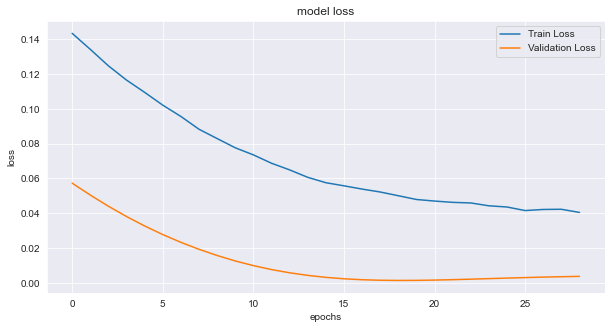

In [35]:
plot_loss(history)

It looks like the EarlyStopping kicked in after validation loss began to steadily climb. Training loss, however looks like it was still decreasing.  Perhaps it was **stopped too early**.

Next we'll check out the Mean Absolute Error and Root Mean Squared Error for both Training and Test values.

In [33]:
LSTM_obtain_error(model)

Train Mean Absolute Error: 2175.851523730888
Train Root Mean Squared Error: 2573.6023398047137
Test Mean Absolute Error: 511.6659545898439
Test Root Mean Squared Error: 633.3491760647648


Our Root Mean Square Error are as follows:

* Train RMSE = 2573.602
* Test RMSE = 633.349

Our model is performing very well on the test set (it's almost half of the test RMSE from our SARIMA model), but the training set RMSE is abysmal (much higher than our SARIMA model).  It may even be underfit.  Let's confirm this by plotting the predictions.  

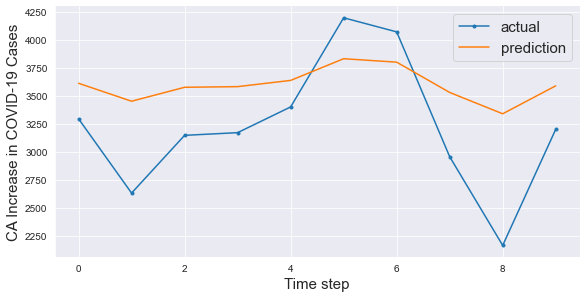

In [37]:
LSTM_prediction_plot(model)

This is looking **underfit**.  The reason for this is our `EarlyStopping` parameter, specifically `patience`.  It's stopping way too early.  Stopping after not seeing improvement after 10 epochs is pretty generous if you're dealing with a huge dataset.  Our training set, however, is only 235. It only took 2 seconds to run through 27 epochs, we want to run 500 epochs since our dataset is so small.  If 27 epochs took 2 seconds, then 500 epochs would take roughly 38 seconds. I think that we can be MUCH more **generous with our** `patience` **parameter**, if not remove it entirely.


## Experiments with Patience

Let's try `patience = 100`.

### Modeling

In [38]:
look_back = 1

X_train, y_train = create_dataset(ca_train, look_back)
X_val, y_val = create_dataset(ca_val, look_back)
X_test, y_test = create_dataset(ca_test, look_back)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_val = np.reshape(X_val, (X_val.shape[0], 1, X_val.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [39]:
es100_model = Sequential()
es100_model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
es100_model.add(Dropout(0.2))
es100_model.add(Dense(1))
es100_model.compile(loss='mean_squared_error', optimizer='adam')

es100_history = es100_model.fit(X_train, y_train, epochs=500, batch_size=70, 
                    validation_data=(X_val, y_val), 
                    callbacks=[EarlyStopping(monitor='val_loss', patience=100)], 
                    verbose=1, shuffle=False)

es100_model.summary()

Train on 233 samples, validate on 5 samples
Epoch 1/500
233/233 [==============================] - 1s 3ms/step - loss: 0.1282 - val_loss: 0.0503
Epoch 2/500
233/233 [==============================] - 0s 64us/step - loss: 0.1196 - val_loss: 0.0439
Epoch 3/500
233/233 [==============================] - 0s 60us/step - loss: 0.1113 - val_loss: 0.0378
Epoch 4/500
233/233 [==============================] - 0s 69us/step - loss: 0.1035 - val_loss: 0.0323
Epoch 5/500
233/233 [==============================] - 0s 69us/step - loss: 0.0957 - val_loss: 0.0272
Epoch 6/500
233/233 [==============================] - 0s 64us/step - loss: 0.0890 - val_loss: 0.0226
Epoch 7/500
233/233 [==============================] - 0s 64us/step - loss: 0.0820 - val_loss: 0.0185
Epoch 8/500
233/233 [==============================] - 0s 73us/step - loss: 0.0774 - val_loss: 0.0149
Epoch 9/500
233/233 [==============================] - 0s 64us/step - loss: 0.0711 - val_loss: 0.0118
Epoch 10/500
233/233 [=================

In [40]:
LSTM_obtain_error(es100_model)

Train Mean Absolute Error: 802.1259769554302
Train Root Mean Squared Error: 1252.6971074825547
Test Mean Absolute Error: 531.804443359375
Test Root Mean Squared Error: 630.1775296889915


After 117 epochs, we've seen a drop in our test RMSE by almost 10 points. Additionally, our the RMSE of our training set was cut in half, making it much lower than the training RMSE of the SARIMA model.  Let's plot out the model loss.

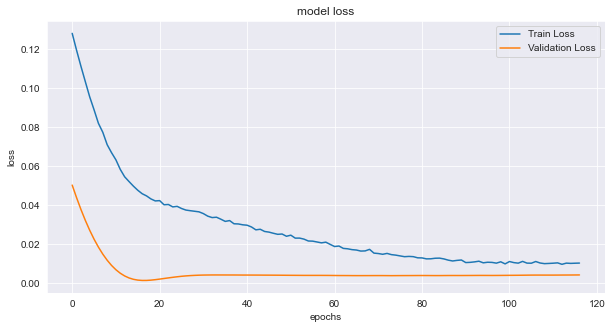

In [41]:
plot_loss(es100_history)

Nice! The loss looks so much better!  Now to plot out the prediction

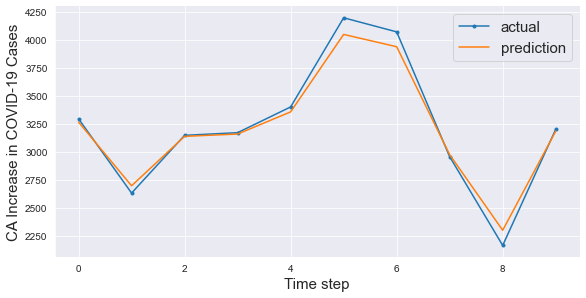

In [42]:
LSTM_prediction_plot(es100_model)

That's looking a lot more fit! Just to satisfy my curiosity let's see what happens if we **let it run the entire 500 epochs**.

In [43]:
look_back = 1

X_train, y_train = create_dataset(ca_train, look_back)
X_val, y_val = create_dataset(ca_val, look_back)
X_test, y_test = create_dataset(ca_test, look_back)

# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_val = np.reshape(X_val, (X_val.shape[0], 1, X_val.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

e500_model = Sequential()
e500_model.add(LSTM(100, input_shape=(X_train.shape[1], X_train.shape[2])))
e500_model.add(Dropout(0.2))
e500_model.add(Dense(1))
e500_model.compile(loss='mean_squared_error', optimizer='adam')

e500_history = e500_model.fit(X_train, y_train, epochs=500, batch_size=70, 
                    validation_data=(X_val, y_val), 
                    #callbacks=[EarlyStopping(monitor='val_loss', patience=10)], 
                    verbose=1, shuffle=False)

model.summary()

Train on 233 samples, validate on 5 samples
Epoch 1/500
233/233 [==============================] - 1s 3ms/step - loss: 0.1252 - val_loss: 0.0491
Epoch 2/500
233/233 [==============================] - 0s 64us/step - loss: 0.1163 - val_loss: 0.0427
Epoch 3/500
233/233 [==============================] - 0s 64us/step - loss: 0.1080 - val_loss: 0.0366
Epoch 4/500
233/233 [==============================] - 0s 69us/step - loss: 0.1004 - val_loss: 0.0311
Epoch 5/500
233/233 [==============================] - 0s 69us/step - loss: 0.0935 - val_loss: 0.0261
Epoch 6/500
233/233 [==============================] - 0s 73us/step - loss: 0.0865 - val_loss: 0.0215
Epoch 7/500
233/233 [==============================] - 0s 79us/step - loss: 0.0800 - val_loss: 0.0175
Epoch 8/500
233/233 [==============================] - 0s 94us/step - loss: 0.0741 - val_loss: 0.0139
Epoch 9/500
233/233 [==============================] - 0s 81us/step - loss: 0.0689 - val_loss: 0.0109
Epoch 10/500
233/233 [=================

233/233 [==============================] - 0s 69us/step - loss: 0.0105 - val_loss: 0.0045
Epoch 159/500
233/233 [==============================] - 0s 69us/step - loss: 0.0096 - val_loss: 0.0045
Epoch 160/500
233/233 [==============================] - 0s 69us/step - loss: 0.0091 - val_loss: 0.0045
Epoch 161/500
233/233 [==============================] - 0s 64us/step - loss: 0.0095 - val_loss: 0.0045
Epoch 162/500
233/233 [==============================] - 0s 64us/step - loss: 0.0096 - val_loss: 0.0045
Epoch 163/500
233/233 [==============================] - 0s 64us/step - loss: 0.0094 - val_loss: 0.0045
Epoch 164/500
233/233 [==============================] - 0s 64us/step - loss: 0.0096 - val_loss: 0.0045
Epoch 165/500
233/233 [==============================] - 0s 64us/step - loss: 0.0099 - val_loss: 0.0044
Epoch 166/500
233/233 [==============================] - 0s 64us/step - loss: 0.0097 - val_loss: 0.0044
Epoch 167/500
233/233 [==============================] - 0s 64us/step - loss: 

Epoch 237/500
233/233 [==============================] - 0s 64us/step - loss: 0.0092 - val_loss: 0.0046
Epoch 238/500
233/233 [==============================] - 0s 69us/step - loss: 0.0093 - val_loss: 0.0046
Epoch 239/500
233/233 [==============================] - 0s 65us/step - loss: 0.0091 - val_loss: 0.0046
Epoch 240/500
233/233 [==============================] - 0s 60us/step - loss: 0.0100 - val_loss: 0.0046
Epoch 241/500
233/233 [==============================] - 0s 73us/step - loss: 0.0104 - val_loss: 0.0046
Epoch 242/500
233/233 [==============================] - 0s 64us/step - loss: 0.0101 - val_loss: 0.0046
Epoch 243/500
233/233 [==============================] - 0s 69us/step - loss: 0.0091 - val_loss: 0.0046
Epoch 244/500
233/233 [==============================] - 0s 64us/step - loss: 0.0093 - val_loss: 0.0046
Epoch 245/500
233/233 [==============================] - 0s 64us/step - loss: 0.0096 - val_loss: 0.0046
Epoch 246/500
233/233 [==============================] - 0s 60us

Epoch 394/500
233/233 [==============================] - 0s 64us/step - loss: 0.0092 - val_loss: 0.0049
Epoch 395/500
233/233 [==============================] - 0s 64us/step - loss: 0.0090 - val_loss: 0.0049
Epoch 396/500
233/233 [==============================] - 0s 60us/step - loss: 0.0092 - val_loss: 0.0050
Epoch 397/500
233/233 [==============================] - 0s 56us/step - loss: 0.0091 - val_loss: 0.0050
Epoch 398/500
233/233 [==============================] - 0s 77us/step - loss: 0.0088 - val_loss: 0.0049
Epoch 399/500
233/233 [==============================] - 0s 64us/step - loss: 0.0088 - val_loss: 0.0049
Epoch 400/500
233/233 [==============================] - 0s 64us/step - loss: 0.0094 - val_loss: 0.0049
Epoch 401/500
233/233 [==============================] - 0s 64us/step - loss: 0.0092 - val_loss: 0.0049
Epoch 402/500
233/233 [==============================] - 0s 64us/step - loss: 0.0082 - val_loss: 0.0049
Epoch 403/500
233/233 [==============================] - 0s 60us

In [44]:
LSTM_obtain_error(e500_model)

Train Mean Absolute Error: 683.8429569031548
Train Root Mean Squared Error: 1170.1226808185556
Test Mean Absolute Error: 576.7921956380209
Test Root Mean Squared Error: 683.6126044693436


The good news is that it only took 11 seconds to do all 500 epochs! The bad news is that the RMSE is the worst that it's ever been (at least from the LSTM Models).

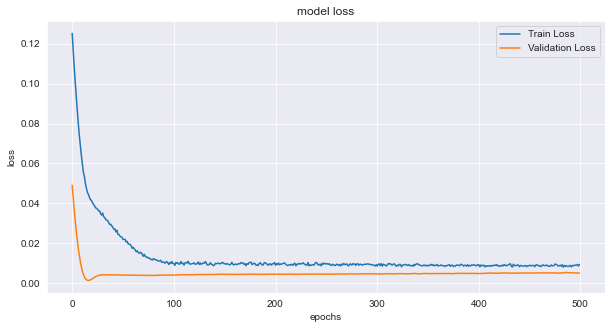

In [45]:
plot_loss(e500_history)

The overall validation loss looks pretty stagnant, the training loss however seems to keep improving, showing that the model is learning the training data better. Possibly overfitting.  Let's look at the predictions.

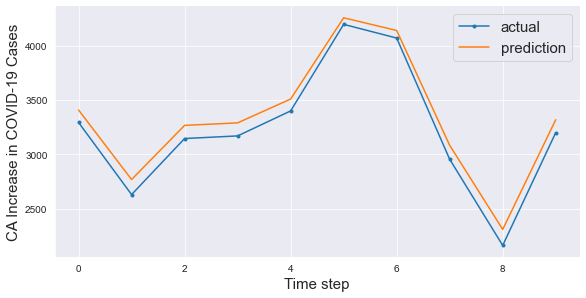

In [46]:
LSTM_prediction_plot(e500_model)

So the **contour remains the same** as our model with a patience of 100, but the difference here is that the predictions are consistently higher in this one.  This stands in contrast to our previous model, `es100`, where they were a little more realistic (higher at times, lower at others).  

Normally, I would prefer a model that is predicting the number of cases to be higher so that the medical facilities can prepare adequately, and if they end up with excess supplies, at least they were able to treat everyone.  The higher RMSE, however, worries me.  It might be higher this time around, but who's to say that will always be the case.

Let's go ahead and save our `es100` model, as it has the lowest RMSE and best performance.  Then we'll move on to Florida.